In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import intake 
import os
import xarray as xr
import cftime

In [43]:
# CMIP6 data catalog location (adjust if needed)
col_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(col_url)

# Search for sea ice velocity components only: siu (u‐component) and siv (v‐component)
query = col.search(
    experiment_id="historical",
    table_id="SImon",
    variable_id=["siu", "siv"]
)

# Convert query to DataFrame
df = query.df
print(df.head())


  activity_id institution_id     source_id experiment_id member_id table_id  \
0        CMIP      NOAA-GFDL      GFDL-CM4    historical  r1i1p1f1    SImon   
1        CMIP      NOAA-GFDL      GFDL-CM4    historical  r1i1p1f1    SImon   
2        CMIP           IPSL  IPSL-CM6A-LR    historical  r5i1p1f1    SImon   
3        CMIP           IPSL  IPSL-CM6A-LR    historical  r5i1p1f1    SImon   
4        CMIP           IPSL  IPSL-CM6A-LR    historical  r6i1p1f1    SImon   

  variable_id grid_label                                             zstore  \
0         siu         gn  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...   
1         siv         gn  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...   
2         siv         gn  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...   
3         siu         gn  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...   
4         siu         gn  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...   

   dcpp_init_year   version  
0             NaN  2

In [67]:
# Count ensembles per model
ensemble_count = df.groupby('source_id')['member_id'].nunique()
ensemble_count_df = ensemble_count.reset_index()
ensemble_count_df.columns = ['Model', 'Number_of_Ensembles']

# Filter models with ≥10 ensembles
filter_df = ensemble_count_df[ensemble_count_df['Number_of_Ensembles'] >= 10]
selected_models = filter_df['Model'].tolist()

print("Models with ≥10 ensembles:\n", selected_models)


Models with ≥10 ensembles:
 ['CESM2', 'CNRM-CM6-1', 'CanESM5', 'GISS-E2-1-G', 'GISS-E2-1-H', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR']


In [32]:
chosen_model = "CESM2" 

filter_model = query.df[query.df['source_id'] == chosen_model]

for _, row in filter_model.iterrows():
    member_id = row['member_id']
    dataset_url = row['zstore']

    print(f"\nEnsemble: {member_id}")

    try:
        ds = xr.open_zarr(dataset_url, consolidated=False) 
        print(f"Available variables: {list(ds.data_vars.keys())}")
    except Exception as e:
        print(f"Failed to open {member_id}: {e}")


Ensemble: r1i1p1f1
Available variables: ['siu']

Ensemble: r5i1p1f1
Available variables: ['siu']

Ensemble: r3i1p1f1


KeyboardInterrupt: 

In [12]:
##############################################
# Full Code for Checking CMIP6 Variables
##############################################

import intake
import pandas as pd
import numpy as np

# 1. Load the CMIP6 data catalog
col_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(col_url)

# 2. Define the variables to query
variables = ['siu', 'siv', 'siconc', 'sfcWind', 'sithick']

# 3. Construct the query
query = col.search(
    experiment_id=['historical'],       # Historical experiment
    table_id=['SImon', 'Amon'],         # Sea ice table (SImon) + atmospheric table (Amon)
    member_id='r1i1p1f1',               # Single ensemble
    variable_id=variables               # Variables of interest
)

# Convert the query result into a DataFrame
df = query.df
print("First 5 rows of the query:")
print(df.head())

##############################################
# 4. Group by Model and Check Variables
##############################################
complete_list = []   # models that have all variables
incomplete = []      # models that miss at least one variable

# Group the query DataFrame by 'source_id' (model name)
for name, group in df.groupby('source_id'):
    # For each variable in 'variables', check if it exists in 'group["variable_id"]'
    check_variables = [v in group['variable_id'].values for v in variables]

    # has_data = True only if *all* requested variables are found
    has_data = np.all(check_variables)

    if has_data:
        # This model has all the requested variables
        complete_list.append(name)
    else:
        # This model is missing at least one variable
        missing = [v for v in variables if v not in group['variable_id'].values]
        # Record info for debugging
        incomplete.append([
            name, 
            len(group),            # number of rows for this model
            ','.join(missing),     # which variables are missing
            has_data               # will be False
        ])

##############################################
# 5. Create a DataFrame of Incomplete Models
##############################################
incomplete_df = pd.DataFrame(
    incomplete, 
    columns=['source_id', 'n_rows', 'missing_variables', 'has_all_variables']
)

##############################################
# 6. Display Results
##############################################
print("\n==========================")
print("Models that have ALL variables:")
print(complete_list)

print("\n==========================")
print("Incomplete Models DataFrame:")
print(incomplete_df)

##############################################
# End of Script
##############################################


First 5 rows of the query:
  activity_id institution_id source_id experiment_id member_id table_id  \
0        CMIP      NOAA-GFDL  GFDL-CM4    historical  r1i1p1f1     Amon   
1        CMIP      NOAA-GFDL  GFDL-CM4    historical  r1i1p1f1    SImon   
2        CMIP      NOAA-GFDL  GFDL-CM4    historical  r1i1p1f1    SImon   
3        CMIP      NOAA-GFDL  GFDL-CM4    historical  r1i1p1f1    SImon   
4        CMIP      NOAA-GFDL  GFDL-CM4    historical  r1i1p1f1    SImon   

  variable_id grid_label                                             zstore  \
0     sfcWind        gr1  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...   
1         siu         gn  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...   
2         siv         gn  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...   
3     sithick         gr  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...   
4     sithick         gn  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...   

   dcpp_init_year   version  
0             NaN

In [52]:
chosen_model = "ACCESS-CM2"
chosen_ensemble = "r1i1p1f1" 
query_filtered = col.df[
    (col.df['source_id'] == chosen_model) &
    (col.df['member_id'] == chosen_ensemble)
]

available_vars = query_filtered['variable_id'].unique()

print(f"Available variables for {chosen_model}, Ensemble {chosen_ensemble}:")
print(sorted(available_vars))


Available variables for ACCESS-CM2, Ensemble r1i1p1f1:
['agessc', 'areacella', 'areacello', 'baresoilFrac', 'basin', 'bigthetao', 'bigthetaoga', 'cl', 'cli', 'clivi', 'clt', 'clw', 'cropFrac', 'deptho', 'difvho', 'evs', 'evspsbl', 'evspsblsoi', 'fracLut', 'fsitherm', 'grassFrac', 'hfds', 'hfls', 'hfss', 'hur', 'hurs', 'hursmax', 'hursmin', 'hus', 'huss', 'masscello', 'mlotst', 'mrro', 'mrros', 'mrso', 'mrsol', 'mrsos', 'msftbarot', 'msftmrho', 'msftmz', 'obvfsq', 'ocontempdiff', 'ocontemppadvect', 'ocontemppmdiff', 'ocontemppsmadvect', 'ocontemprmadvect', 'ocontemptend', 'od550aer', 'orog', 'osaltdiff', 'osaltpadvect', 'osaltpmdiff', 'osaltpsmadvect', 'osaltrmadvect', 'osalttend', 'pbo', 'pfull', 'phalf', 'pr', 'prc', 'prra', 'prsn', 'prw', 'ps', 'psl', 'rlds', 'rlntds', 'rlus', 'rlut', 'rlutcs', 'rsdoabsorb', 'rsds', 'rsdscs', 'rsdt', 'rsntds', 'rsus', 'rsuscs', 'rsut', 'rsutcs', 'rtmt', 'sfcWind', 'sfcWindmax', 'sftgif', 'sftlf', 'sftof', 'shrubFrac', 'siconc', 'siconca', 'simass', '

In [53]:
chosen_model = "CESM2"
print(f"{chosen_model}, {member_id}")
print("Available variables:", list(ds.data_vars.keys()))


CESM2, r7i1p1f1
Available variables: ['siu', 'vertices_latitude', 'vertices_longitude', 'siv']


In [65]:
chosen_model = "CESM2"
chosen_ensemble = "r1i1p1f1" 
query_filtered = col.df[
    (col.df['source_id'] == chosen_model) &
    (col.df['member_id'] == chosen_ensemble)
]

available_vars = query_filtered['variable_id'].unique()

print("Data variables:", list(ds.data_vars.keys()))
print("Coordinates:", list(ds.coords.keys()))

print(f"Available variables for {chosen_model}, Ensemble {chosen_ensemble}:")
print(ds.data_vars.keys())


Data variables: ['siv']
Coordinates: ['lat', 'lat_bnds', 'lon', 'lon_bnds', 'ni', 'nj', 'time', 'time_bnds']
Available variables for CESM2, Ensemble r1i1p1f1:
KeysView(Data variables:
    siv      (time, nj, ni) float32 dask.array<chunksize=(933, 384, 320), meta=np.ndarray>)


In [74]:
import os
import xarray as xr
import cftime
import numpy as np
import pandas as pd
import intake

output_dir = "sea_ice_velocity_data_no_siconc"
os.makedirs(output_dir, exist_ok=True)

for chosen_model in selected_models:
    print(f"Processing model: {chosen_model}")

    filter_model = df[df['source_id'] == chosen_model]
    
    velocity_data = {}
    
    # Group by ensemble (member_id)
    for member_id, group in filter_model.groupby('member_id'):
        print(f"  Processing ensemble: {member_id}")
  
        available_vars = set(group['variable_id'])
        if not {'siu', 'siv'}.issubset(available_vars):
            print(f"    Missing one variable for ensemble {member_id}.")
            continue
        
        try:
            row_siu = group[group['variable_id'] == 'siu'].iloc[0]
            row_siv = group[group['variable_id'] == 'siv'].iloc[0]
            
            ds_siu = xr.open_zarr(row_siu['zstore'], consolidated=True)
            ds_siv = xr.open_zarr(row_siv['zstore'], consolidated=True)
            print("    Loaded both siu and siv datasets.")
            
            # Merge siu and siv
            ds = xr.merge([ds_siu, ds_siv], compat='override')
            print("    Merged datasets.")
            
            # time filter
            time_vals = ds['time'].values
            if isinstance(time_vals[0], cftime.datetime):
                time_mask = time_vals >= cftime.DatetimeNoLeap(2000, 1, 1)
            else:
                time_mask = time_vals >= np.datetime64('2000-01-01')
            ds_time = ds.sel(time=time_mask)
            
            # lat
            if 'lat' in ds_time.coords:
                lat = ds_time['lat']
            elif 'latitude' in ds_time.coords:
                lat = ds_time['latitude']
            elif 'nav_lat' in ds_time.coords:
                lat = ds_time['nav_lat']
            else:
                print(f"    No lat variable for ensemble {member_id}.")
                continue
            
            # lat mask 
            lat_mask = (lat >= 75).compute()
            ds_north_75 = ds_time.where(lat_mask, drop=True)
            
            # spatial dims 
            if {'j', 'i'}.issubset(ds_north_75.dims):
                spatial_dims = ['j', 'i']
            elif {'y', 'x'}.issubset(ds_north_75.dims):
                spatial_dims = ['y', 'x']
            elif {'lat', 'lon'}.issubset(ds_north_75.dims):
                spatial_dims = ['lat', 'lon']
            elif {'nj', 'ni'}.issubset(ds_north_75.dims):
                spatial_dims = ['nj', 'ni']
            else:
                print(f"    Unknown spatial dims for ensemble {member_id}.")
                continue
            
            # velocity magnitude from siu and siv
            siu = ds_north_75['siu']
            siv = ds_north_75['siv']
            velocity_magnitude = np.sqrt(siu**2 + siv**2)
            
            # area weighting if available; otherwise, use ones
            if 'area' in ds_north_75.data_vars:
                area = ds_north_75['area']
            else:
                area = xr.ones_like(velocity_magnitude)

            total_vel = (velocity_magnitude * area).sum(dim=spatial_dims)
            total_area = area.sum(dim=spatial_dims)
            mean_vel = total_vel / total_area

            mean_vel_series = mean_vel.to_series()
            velocity_data[member_id] = mean_vel_series
            
        except Exception as e:
            print(f"    Failed to process: {e}")

    if velocity_data:
        velocity_df = pd.DataFrame(velocity_data)
        csv_filename = f"{output_dir}/{chosen_model}_sea_ice_velocity_no_siconc.csv"
        velocity_df.to_csv(csv_filename)
        print(f"Saved.")
    else:
        print(f"No velocity data to save.")

Processing model: CESM2
  Processing ensemble: r10i1p1f1
    Missing one variable for ensemble r10i1p1f1.
  Processing ensemble: r1i1p1f1
    Loaded both siu and siv datasets.
    Merged datasets.
  Processing ensemble: r2i1p1f1
    Missing one variable for ensemble r2i1p1f1.
  Processing ensemble: r3i1p1f1
    Missing one variable for ensemble r3i1p1f1.
  Processing ensemble: r4i1p1f1
    Loaded both siu and siv datasets.
    Merged datasets.
  Processing ensemble: r5i1p1f1
    Loaded both siu and siv datasets.
    Merged datasets.
  Processing ensemble: r6i1p1f1
    Loaded both siu and siv datasets.
    Merged datasets.
  Processing ensemble: r7i1p1f1
    Loaded both siu and siv datasets.
    Merged datasets.
  Processing ensemble: r8i1p1f1
    Missing one variable for ensemble r8i1p1f1.
  Processing ensemble: r9i1p1f1
    Missing one variable for ensemble r9i1p1f1.
Saved.
Processing model: CNRM-CM6-1
  Processing ensemble: r10i1p1f2
    Loaded both siu and siv datasets.
    Merged d

In [69]:
print("Merged dataset dims:", ds.dims)
print("After latitude filter dims:", ds_north_75.dims)

Merged dataset dims: Frozen({'nj': 384, 'ni': 320, 'nvertices': 4, 'time': 1980, 'd2': 2})
After latitude filter dims: Frozen({'time': 180, 'nj': 336, 'ni': 320, 'nvertices': 4, 'd2': 2})


In [84]:
chosen_model = "CESM2"
filter_model = df[df['source_id'] == chosen_model]

for member_id, group in filter_model.groupby('member_id'):
    print(f"Ensemble {member_id} has variables:", group['variable_id'].unique())
    
# print(df[df['member_id'] == "r10i1p1f1"].T)

Ensemble r10i1p1f1 has variables: ['siu']
Ensemble r1i1p1f1 has variables: ['siu' 'siv']
Ensemble r2i1p1f1 has variables: ['siu']
Ensemble r3i1p1f1 has variables: ['siu']
Ensemble r4i1p1f1 has variables: ['siu' 'siv']
Ensemble r5i1p1f1 has variables: ['siu' 'siv']
Ensemble r6i1p1f1 has variables: ['siu' 'siv']
Ensemble r7i1p1f1 has variables: ['siu' 'siv']
Ensemble r8i1p1f1 has variables: ['siu']
Ensemble r9i1p1f1 has variables: ['siu']


In [85]:
query_siv = col.search(
    experiment_id="historical",
    table_id="SImon",
    variable_id="siv",
    source_id=chosen_model
)
print(query_siv.df)

  activity_id institution_id source_id experiment_id member_id table_id  \
0        CMIP           NCAR     CESM2    historical  r1i1p1f1    SImon   
1        CMIP           NCAR     CESM2    historical  r5i1p1f1    SImon   
2        CMIP           NCAR     CESM2    historical  r6i1p1f1    SImon   
3        CMIP           NCAR     CESM2    historical  r7i1p1f1    SImon   
4        CMIP           NCAR     CESM2    historical  r4i1p1f1    SImon   

  variable_id grid_label                                             zstore  \
0         siv         gn  gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...   
1         siv         gn  gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r5...   
2         siv         gn  gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r6...   
3         siv         gn  gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r7...   
4         siv         gn  gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4...   

   dcpp_init_year   version  
0             NaN  20191216  
1             

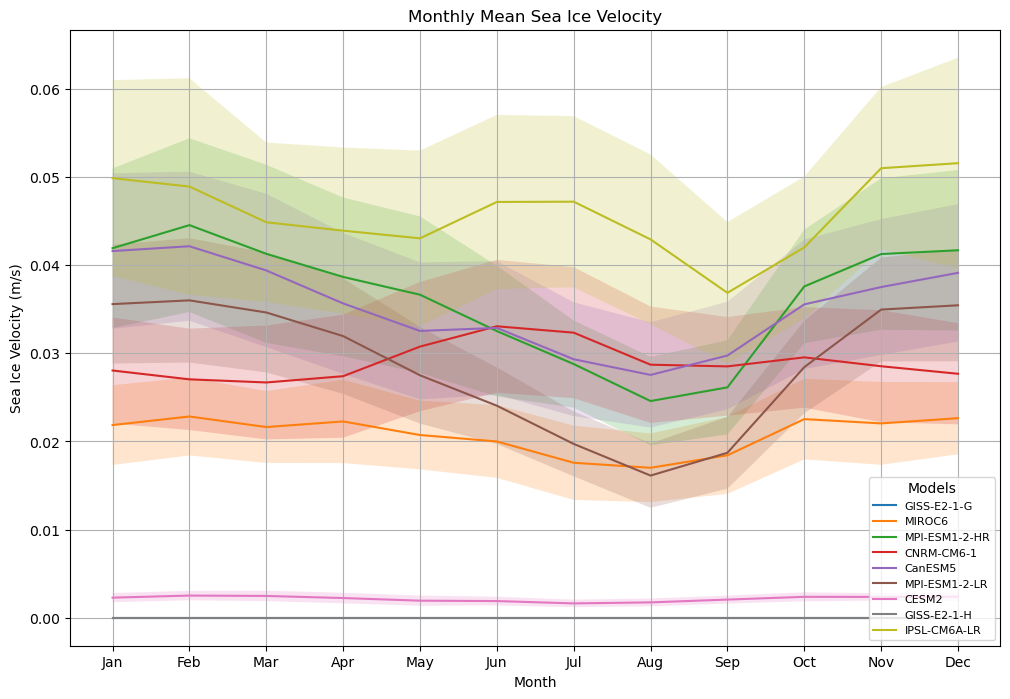

In [87]:
csv_dir = "sea_ice_velocity_data/"
csv_files = glob.glob(f"{csv_dir}*_sea_ice_velocity_no_siconc.csv")

model_monthly_means = {}
model_monthly_stds = {}

for csv_file in csv_files:
    model_name = csv_file.split("/")[-1].replace("_sea_ice_velocity_no_siconc.csv", "")

    velocity_df = pd.read_csv(csv_file, index_col=0, parse_dates=True)

    monthly_mean = velocity_df.groupby(velocity_df.index.month).mean().mean(axis=1)
    monthly_std = velocity_df.groupby(velocity_df.index.month).std().mean(axis=1)

    model_monthly_means[model_name] = np.array(monthly_mean)
    model_monthly_stds[model_name] = np.array(monthly_std)

monthly_means_df = pd.DataFrame(model_monthly_means)
monthly_stds_df = pd.DataFrame(model_monthly_stds)

month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_values = np.arange(1, 13)

plt.figure(figsize=(12, 8))

for model_name in monthly_means_df.columns:
    mean_values = monthly_means_df[model_name].values
    std_values = monthly_stds_df[model_name].values

    plt.plot(month_values, mean_values, label=model_name)
    plt.fill_between(month_values, mean_values - std_values, mean_values + std_values, alpha=0.2)

plt.title('Monthly Mean Sea Ice Velocity')
plt.xlabel('Month')
plt.ylabel('Sea Ice Velocity (m/s)')
plt.xticks(month_values, month_labels)
plt.legend(title='Models', loc='lower right', fontsize=8)
plt.grid(True)
plt.show()